In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
base.prepare(engine, reflect=True)

# reflect the tables
measurement = base.classes.measurement
station = base.classes.station

C:\Users\nugen\AppData\Local\Temp\ipykernel_27800\564732665.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
all_classes = base.classes.keys()
print(all_classes)

['station', 'measurement']


In [7]:
# Save references to each table
measurement_df = pd.read_sql("SELECT * FROM measurement", engine)
station_df = pd.read_sql("SELECT * FROM station", engine)

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
#Find the most recent date in the data set.
latest_date = session.query(func.max(measurement.date)).scalar()
latest_date

'2017-08-23'

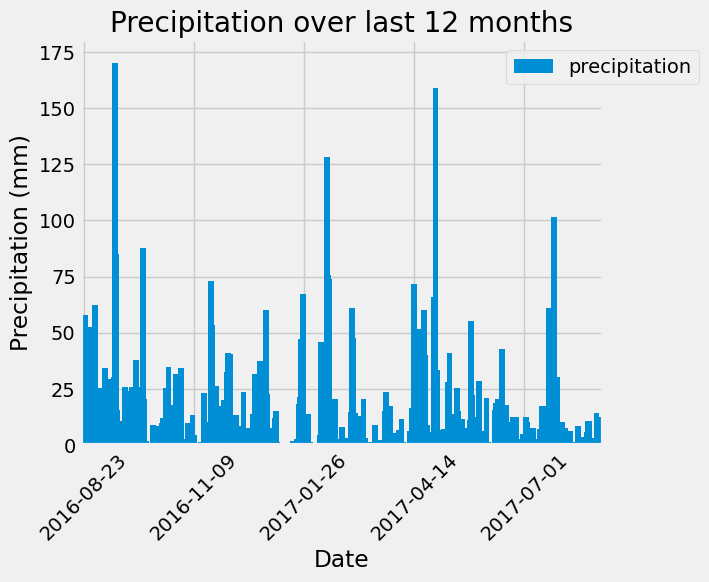

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

# Calculate the date 12 months ago from the latest date
one_year_ago = latest_date - dt.timedelta(days=365)

# Query to retrieve precipitation data for the last 12 months
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago.strftime('%Y-%m-%d')).\
    order_by(measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
precipitation_df

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')
max_precipitation_df = precipitation_df.groupby('date', as_index=False).max()

step = len(max_precipitation_df)//5 +5

#Use Pandas Plotting with Matplotlib to plot the data
max_precipitation_df.plot(kind='bar', figsize=(6, 5), width=4)
plt.title('Precipitation over last 12 months')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')

# Show only every 30th x-label for better visibility
plt.xticks(range(0, len(max_precipitation_df.index), step), max_precipitation_df['date'][::step], rotation=45)
plt.ylim(0, max_precipitation_df['precipitation'].max() + 10)
plt.legend(loc='upper center', bbox_to_anchor=(1,1))

plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['precipitation'].describe()
summary_stats = pd.DataFrame(summary_stats)
summary_stats

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count()).select_from(station).scalar()
print(station_count)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations = session.query(measurement.station, func.count().label('station_count')).\
    group_by(measurement.station).\
    order_by(func.count().desc()).all()

# Print the results
for station, count in stations:
    print(f"{station}: {count}")


USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stations = pd.DataFrame(stations)

top_station = stations['station'].iloc[0]

top_station_df = []

for index, row in measurement_df.iterrows():
    row_tuple = row['station'], row['tobs']

    if top_station == row['station'] and not pd.isna(row['tobs']):
        top_station_df.append(row_tuple)

top_station_df = pd.DataFrame(top_station_df, columns=['Station', 'Temperature (c)'])

In [15]:
summary_stats = top_station_df['Temperature (c)'].describe()

min = summary_stats['min']
max = summary_stats['max']
mean = summary_stats['mean']

print(min, max, mean)

12.2 29.4 22.035822510822513


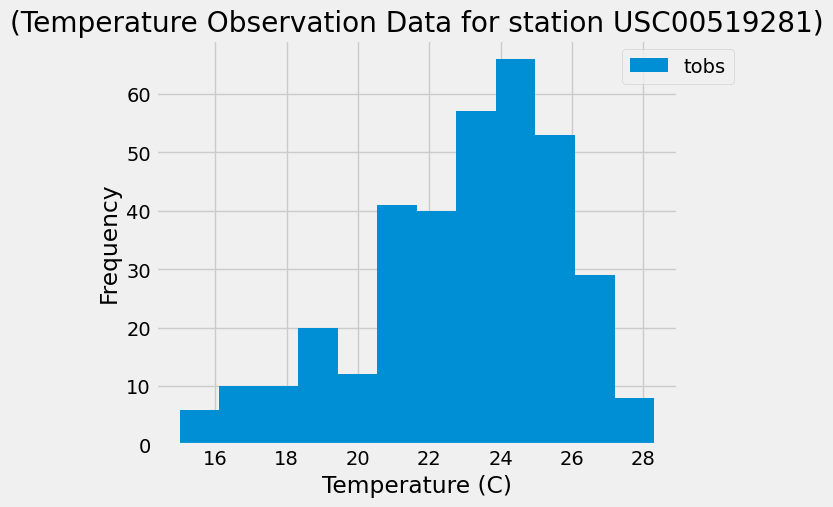

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station_tobs_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == top_station).\
    filter(measurement.date >= one_year_ago.strftime('%Y-%m-%d')).all()

top_station_tobs_df = pd.DataFrame(top_station_tobs_data, columns=['date', 'tobs'])
top_station_tobs_df

top_station_tobs_df.plot.hist(bins=12, figsize=(6,5))
plt.title(f'(Temperature Observation Data for station {top_station})')
plt.xlabel('Temperature (C)')
plt.ylabel('Frequency')
plt.legend(loc='upper center', bbox_to_anchor=(1,1))
plt.show()

In [17]:
session.close()